In [3]:
from nilearn.glm.first_level import FirstLevelModel
from nilearn import image
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from pathlib import Path

In [5]:
cwd = os.getcwd()

path = cwd +  '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-01_bold.nii'

path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_bold.nii'
fmri_img = image.load_img(path)
fmri_img2 = image.load_img(path2)
fmri_img = image.concat_imgs([fmri_img, fmri_img2])
events_path = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-01_events.tsv'
events_path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_events.tsv'

events = pd.read_csv(events_path, sep='\t', usecols=[0, 1, 2])

# events2 = events2.iloc[1:]

# events_path2 = cwd + '/../fMRI_Data/sub-001/func/sub-001_task-Training_run-02_events.tsv'
# events2 = pd.read_csv(events_path2, sep='\t', usecols=[0, 1, 2])
# events2.iloc[:, 0] += 615
# events2.index += 41
# events = pd.concat([events, events2])

events.rename(columns={events.columns[2]: 'trial_type'}, inplace=True)
events['trial_type'] = events['trial_type'].str.strip("'") # remove single quotes from trial_type column

print(events.tail(50))
print(events.shape)





FileNotFoundError: [Errno 2] No such file or directory: 'fMRI_Data/sub-001/func/sub-001_task-Training_run-01_events.tsv'

In [ ]:
fmri_glm = FirstLevelModel(
    t_r=1.5,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)

fmri_glm = fmri_glm.fit(fmri_img, events)


In [ ]:
design_matrix = fmri_glm.design_matrices_[0]
print(design_matrix.sum(axis=0))



blues        8.000000e+01
classical    8.033394e+01
country      8.000030e+01
disco        9.000000e+01
hiphop       8.000000e+01
jazz         8.000000e+01
metal        9.000000e+01
pop          7.649127e+01
reggae       8.000000e+01
rock         8.000000e+01
drift_1      1.512679e-15
drift_2     -1.637579e-15
drift_3      2.400857e-15
drift_4     -1.311451e-15
drift_5      1.144917e-15
drift_6     -1.464107e-15
drift_7      1.498801e-15
drift_8     -1.998401e-15
drift_9      3.580469e-15
drift_10    -1.859624e-15
drift_11     3.108624e-15
drift_12    -2.851885e-15
drift_13     3.226586e-15
drift_14    -3.767819e-15
drift_15     2.602085e-15
drift_16    -2.539635e-15
drift_17     3.358425e-15
drift_18    -2.851885e-15
drift_19     4.531098e-15
drift_20    -2.074729e-15
drift_21     2.872702e-15
drift_22    -5.204170e-16
drift_23     2.553513e-15
drift_24    -4.635181e-15
constant     8.200000e+02
dtype: float64


In [ ]:
print(events['trial_type'].unique())

['disco' 'blues' 'hiphop' 'pop' 'jazz' 'classical' 'country' 'metal'
 'reggae' 'rock']


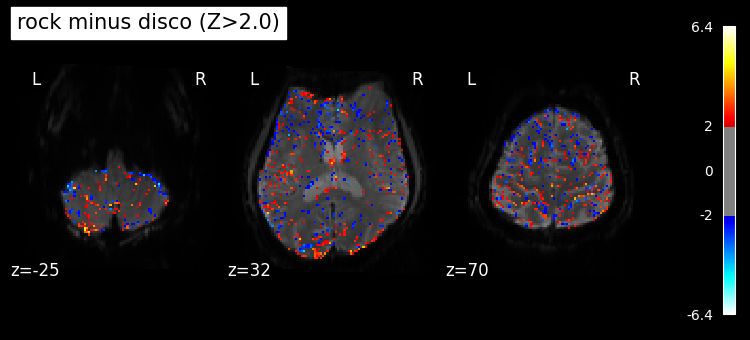

In [ ]:
from nilearn.plotting import plot_stat_map, plot_contrast_matrix
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

# Specify your contrast; for example, comparing condition 'A' vs 'B'
cond_a, cond_b = 'rock', 'disco'
contrast_def = basic_contrasts['rock'] - basic_contrasts['disco']

# Compute the contrast
z_map = fmri_glm.compute_contrast(contrast_def, output_type='z_score')
# eff_map = fmri_glm.compute_contrast(contrast_def, output_type='effect_size')
mean_img = image.mean_img(fmri_img)
# plot_stat_map(z_map, threshold=0.8, display_mode='z', cut_coords=3, title='Condition A vs B')
# plot_contrast_matrix(contrast_def, design_matrix=design_matrix)
threshold = 2.0
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (Z>{threshold})"
)
plt.show()


Uncorrected p<0.001 threshold: 3.291


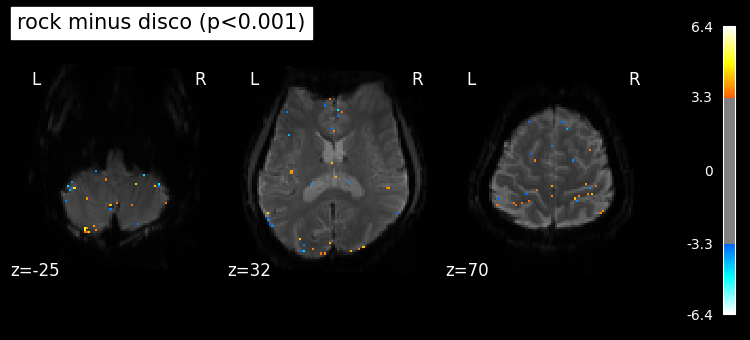

In [ ]:
from nilearn.glm import threshold_stats_img
alpha = 0.001
_, threshold = threshold_stats_img(z_map, alpha=alpha, height_control="fpr")
print(f"Uncorrected p<{alpha} threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (p<{alpha})",
)
plt.show()

Bonferroni-corrected, p<0.05 threshold: 4.567


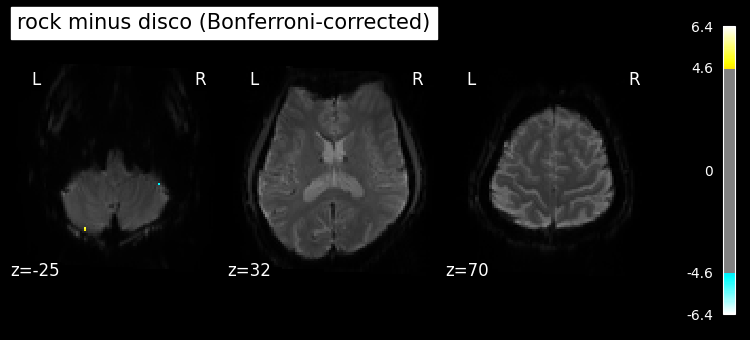

In [ ]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.9, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (Bonferroni-corrected)",
)
plt.show()

False Discovery rate = 0.05 threshold: 3.084


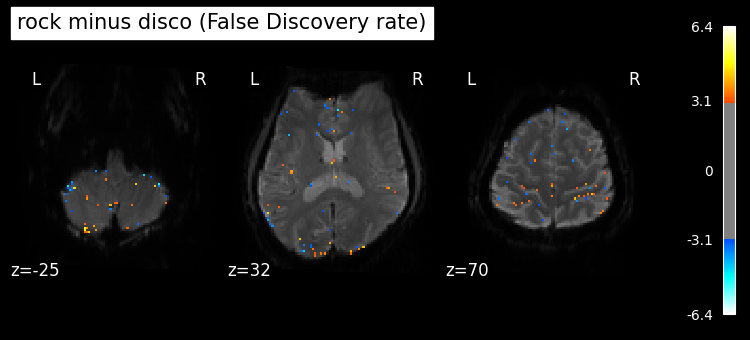

In [ ]:
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title=f"{cond_a} minus {cond_b} (False Discovery rate)",
)
plt.show()

Output will be saved to: c:\EiT\EiT-Group5\results\plot_single_subject_single_run
Design matrix has shape 820 rows and 35 columns
First few columns are Index(['blues', 'classical', 'country', 'disco', 'hiphop'], dtype='object')


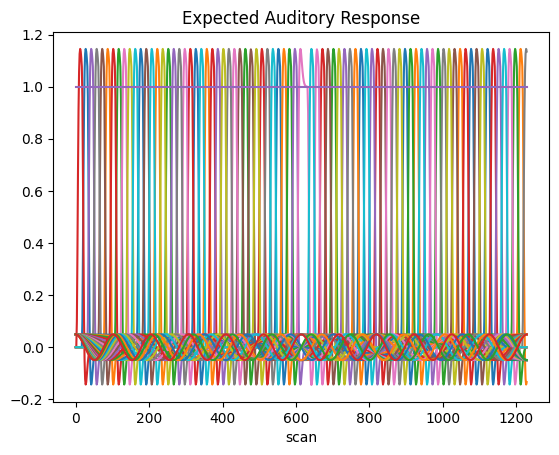

In [ ]:
# plot_design_matrix(design_matrix)

output_dir = Path.cwd() / "results" / "plot_single_subject_single_run"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

plot_design_matrix(design_matrix, output_file=output_dir / "design_matrix.png")

print(f"Design matrix has shape {design_matrix.shape[0]} rows and {design_matrix.shape[1]} columns")
print(f"First few columns are {design_matrix.columns[:5]}")
plt.plot(design_matrix)
plt.xlabel("scan")
plt.title("Expected Auditory Response")
plt.show()

# condition_names = events["trial_type"].unique()
# conditions = {}
# for i, condition in enumerate(condition_names):
#     conditions[condition] = np.zeros(design_matrix.shape[0])
#     conditions[condition][i] = 1
# print(conditions)